Mejores parámetros: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Modelo exportado exitosamente.
MAE: 104.60209778729246
RMSE: 124.44457590450124
MAPE: 27.874126827713813%
Accuracy: 72.12587317228619%
Órdenes predichas para 2024-07-01: 316.1987980022475


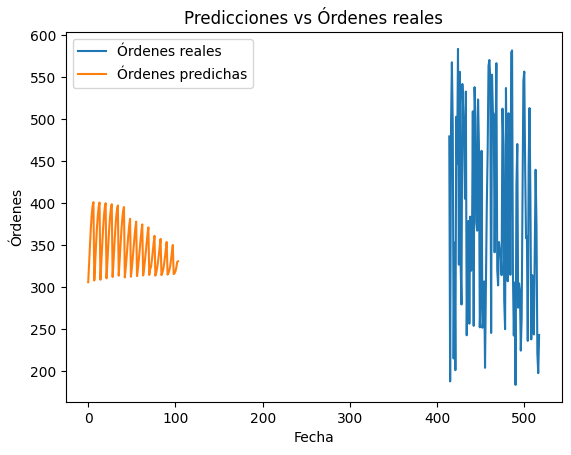

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib  # Biblioteca para guardar el modelo
import statsmodels.api as sm

# Generar fechas
start_date = '2023-01-01'
end_date = '2024-06-01'
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Generar órdenes aleatorias con una tendencia lineal y estacionalidad
np.random.seed(42)
orders = np.random.randint(100, 500, size=len(dates)) + np.arange(len(dates)) * 0.5 + np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 100

# Detrend the data
trend = np.arange(len(dates)) * 0.5
orders_detrended = orders - trend

# Crear DataFrame
df = pd.DataFrame({'ds': dates, 'y': orders_detrended})

# Agregar características adicionales
df['day_of_week'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['quarter'] = df['ds'].dt.quarter
df['day_of_year'] = df['ds'].dt.dayofyear
df['week_of_year'] = df['ds'].dt.isocalendar().week

# Convertir fechas a ordinales
df['ds'] = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal)

# Preparar los datos para el entrenamiento
X = df[['ds', 'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year']]
y = df['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de hiperparámetros usando GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Entrenar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Exportar el modelo entrenado
joblib.dump(best_model, 'modelo_svr_god.pkl')
joblib.dump(scaler, 'scaler_god.pkl')  # También exportar el escalador

print("Modelo exportado exitosamente.")

# Realizar predicciones
y_pred = best_model.predict(X_test_scaled)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"Accuracy: {accuracy}%")

# Predicción para una fecha específica
specific_date = '2024-07-01'
specific_date_ordinal = pd.to_datetime(specific_date).toordinal()
specific_features = pd.DataFrame({
    'ds': [specific_date_ordinal],
    'day_of_week': [pd.to_datetime(specific_date).dayofweek],
    'month': [pd.to_datetime(specific_date).month],
    'quarter': [pd.to_datetime(specific_date).quarter],
    'day_of_year': [pd.to_datetime(specific_date).dayofyear],
    'week_of_year': [pd.to_datetime(specific_date).isocalendar()[1]]
})

specific_features_scaled = scaler.transform(specific_features)
predicted_order = best_model.predict(specific_features_scaled)

print(f"Órdenes predichas para {specific_date}: {predicted_order[0]}")

# Visualizar las predicciones

plt.plot(y_test, label='Órdenes reales')
plt.plot(y_pred, label='Órdenes predichas')
plt.xlabel('Fecha')
plt.ylabel('Órdenes')
plt.title('Predicciones vs Órdenes reales')
plt.legend()
plt.show()